In [1]:
#import the standard libraries first and the standard ipython magic functions

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import glob, os, sys, pickle, random

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [8]:
#These parameters are hyperparameters that we 
#have to search through to find a good value. For now,
#I've done most of the hard work for you! With these
#hyperparameters you should get around ~86% accuracy.

batch_size = 128
l2_reg_parameter = 0.001
lr_decay = 0.92
learning_rate = 1e-3

In [3]:
#check first if we have the files downloaded. If they haven't been,
#download them! I was lazy and there is no download progress 
#marker, but the file is around 200mb so it might take a while.

#After running this cell, you wil have three data structures:
#data_train is a dictionary with the data and labels for the training set
#data_test is a dictionary with the data and labels for the test set
#meta_data just simply maps the class index (0-9) to the actual name of the
#class (e.g. automobile, cat, etc.)

cifar_dir = 'cifar-10-batches-py'
batchfiles = glob.glob(cifar_dir+'/*_batch*')

if len(batchfiles)!=6:
    print('downloading cifar dataset. this may take a little bit...')
    os.system('wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz')
    print('download complete! unzipping...')
    os.system('tar -xvf cifar-10-python.tar.gz')
    print('Done!')
else:
    print('cifar dataset detected. proceeding...')
    
batchfiles = glob.glob(cifar_dir+'/*_batch*')

data_train = {}
data_train['data'] = []
data_train['labels'] = []
for file in batchfiles:
    if 'test' in file:
        data_batch = pickle.load(open(file,'rb'), encoding='bytes')
        data_test = {}
        data_test['data'] = data_batch[b'data']
        data_test['labels'] = data_batch[b'labels']
    else:
        data_batch = pickle.load(open(file,'rb'), encoding='bytes')
        data_train['data'].append(data_batch[b'data'])
        data_train['labels'].append(data_batch[b'labels'])
data_train['data'] = np.concatenate(data_train['data'],axis=0)
data_train['labels'] = np.concatenate(data_train['labels'],axis=0)

meta_data = pickle.load(open(cifar_dir+'/batches.meta','rb'), encoding='bytes')
meta_data = [item.decode('utf-8') for item in meta_data[b'label_names']]

print('dataset loaded!')

cifar dataset detected. proceeding...
dataset loaded!


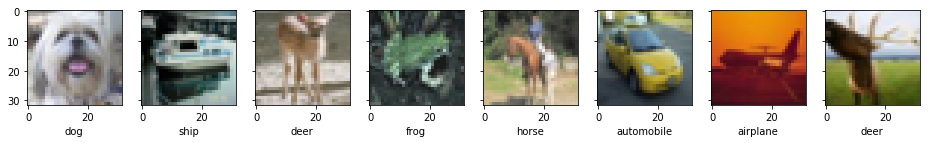

In [4]:
#Let's visualize 8 random images in the training set, along with their training labels. 
#Note that we have to reshape the images and do some transposes before they are 
#the right shape (32, 32, 3)

idxes = np.random.choice(50000,8,replace=False)
images = data_train['data'][idxes]

f, ax = plt.subplots(1,8, sharey = True, figsize=(16,2))
for i in range(8):
    ax[i].imshow(np.resize(images[i],[3,32,32]).transpose(1,2,0))
    ax[i].set_xlabel(meta_data[data_train['labels'][idxes[i]]])
plt.show()

In [5]:
#Let's now create the dataset, using the inbuild Dataset class in pytorch.
#The Dataset class needs 3 methods defined: __init__, __len__, and __getitem__

class CIFAR10Dataset(Dataset):
    
    def __init__(self, data):
        #initialize the dataset with the actual data
        #in general, if you don't want to fit the entire
        #dataset into memory (often the case),
        #it's often recommended to put an array of 
        #filenames here
        
        self.data = data['data']
        self.labels = data['labels']
        
    def __len__(self):
        #just has to return the number of entries in the dataset. 
        #pretty straightforward
        
        return len(self.labels)
    
    def __getitem__(self, idx):
        #getitem allows you to interact with the Dataset object
        #like a standard array. It actually loads the real data in.
        #For example you can get the third data point by calling my_dataset[3]
        
        return {'data':np.resize(np.array(self.data[idx],dtype=np.float32),[3,32,32]),
                'label':self.labels[idx]}

#We have to initialize one dataset and dataloader for the training set, and one for the test set now.
#The num_workers option allows PyTorch to use idle CPUs to lazily load datapoints for you, and
#is recommended as it should speed up training. 

#batch_size is one of the most important hyperparameters in deep learning. It determines
#how many datapoints are used per iteration of training your model. Here it is set to 128;
#there is no grand consensus on how to pick batch_size, and it is still an active area of research!

dataset_train = CIFAR10Dataset(data_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers = 1)

dataset_test = CIFAR10Dataset(data_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers = 1)

In [6]:
#Let's now get to the fun part: defining your network!

class MyFirstNeuralNetwork(nn.Module):
    
    def __init__(self):
        
        #The first thing to define is your __init__ function.
        #All model classes inherit from nn.Module.
        #First we initialize the superclass as follows:
        
        super(MyFirstNeuralNetwork, self).__init__()
        
        #Next, we actually create all of the weights that are trained.
        #Each of the following calls defines a set of weights along with an operation
        #they are associated with.
        
        #Tecnically, we could just create all the weights here and then define their operatoins later.
        #But PyTorch gives you so many nice clean inbuilt functions that it's much easier to do it this way.
        #You don't have to worry about each of these right now, just know that each of them
        #basically corresponds to a layer that takes in some input and puts out some output.
        
        self.filter1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 7, padding = 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size = 2)
        
        #nn.Sequential is a particularly useful function - it tells the model a specific order you
        #want to chain up operations. In this case, we apply filter1, then bn1, then relu1, then pool1
        self.firstblock = nn.Sequential(self.filter1, self.bn1, self.relu1, self.pool1)
        
        self.filter2a = nn.Conv2d(in_channels = 32, out_channels = 128, kernel_size = 3, padding = 1)
        self.bn2a = nn.BatchNorm2d(128)
        self.relu2a = nn.ReLU()
        self.filter2b = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1)
        self.bn2b = nn.BatchNorm2d(128)
        self.relu2b = nn.ReLU()
        self.filter2c = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1)
        self.bn2c = nn.BatchNorm2d(128)
        self.relu2c = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size = 2)
        
        self.secondblock = nn.Sequential(self.filter2a, nn.Dropout2d(p=0.2), self.bn2a, self.relu2a, self.filter2b, \
                                         nn.Dropout2d(p=0.2), self.bn2b, self.relu2b, self.filter2c, \
                                         nn.Dropout2d(p=0.2), self.bn2c, self.relu2c, self.pool2)
        
        self.filter3a = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1)
        self.bn3a = nn.BatchNorm2d(256)
        self.relu3a = nn.ReLU()
        self.filter3b = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1)
        self.bn3b = nn.BatchNorm2d(256)
        self.relu3b = nn.ReLU()
        self.filter3c = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1)
        self.bn3c = nn.BatchNorm2d(256)
        self.relu3c = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size = 2)
        
        self.thirdblock = nn.Sequential(self.filter3a, nn.Dropout2d(p=0.2), self.bn3a, self.relu3a, self.filter3b, \
                                         nn.Dropout2d(p=0.2), self.bn3b, self.relu3b, self.filter3c, \
                                         nn.Dropout2d(p=0.2), self.bn3c, self.relu3c, self.pool3)
        
        
        self.filter4a = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1)
        self.bn4a = nn.BatchNorm2d(512)
        self.relu4a = nn.ReLU()
        self.filter4b = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1)
        self.bn4b = nn.BatchNorm2d(512)
        self.relu4b = nn.ReLU()
        self.filter4c = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1)
        self.bn4c = nn.BatchNorm2d(512)
        self.relu4c = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size = 2)
        
        self.fourthblock = nn.Sequential(self.filter4a, nn.Dropout2d(p=0.2), self.bn4a, self.relu4a, self.filter4b, \
                                         nn.Dropout2d(p=0.2), self.bn4b, self.relu4b, self.filter4c, \
                                         nn.Dropout2d(p=0.2), self.bn4c, self.relu4c, self.pool4)
        
        self.fc1 = nn.Sequential(nn.Linear(2048, 1024), nn.Dropout(p=0.5), nn.BatchNorm1d(1024), nn.ReLU())
        self.classifier_head = nn.Linear(1024, 10)
    
    def forward(self, input):
        
        #This method now actually implements the forward pass of our network (going from input to output)
        #Note that happily, we've done basically all of the work already in the __init__ method. 
        #All we really have to do is chain up everything in a nice neat package.
        
        N,C,H,W = input.shape
        out = self.firstblock(input)
        out = self.secondblock(out)
        out = self.thirdblock(out)
        out = self.fourthblock(out)
        
        #out.view(N,-1) flattens the out tensor.
        out = out.view(N,-1)
        
        out = self.fc1(out)
        out = self.classifier_head(out)
        
        return out
    
#Now let's actually instantiate a network.
        
model = MyFirstNeuralNetwork()

#And make sure it runs on GPU
model = model.cuda()

#Now let's define our loss function. In this case we use Cross Entropy loss.
#We will use this to quantitatively define how far our model predictions are 
#from the ground truth values. 
criterion = nn.CrossEntropyLoss()

#We also define our optimizer (usually some variant of gradient descent.)
#In this case we use Adam - almost always a safe choice!
optimizer = optim.Adam(model.parameters(),lr = learning_rate,weight_decay = l2_reg_parameter)

In [ ]:
#Now we actually train our model!

for epoch in range(100):

    data_train_enum = enumerate(dataloader_train)

    for step, data in data_train_enum:
        network_input = data['data']
        data_labels = data['label']

        forward_output = model.forward(network_input.cuda())

        loss = criterion(forward_output, data_labels.cuda())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if step%250==0:
            model.eval()
            data_test_enum = enumerate(dataloader_test)
            accuracy = 0.0
            total_N = 0.0
            test_loss = 0.0
            for step, data in data_test_enum:
                
                network_input = data['data']
                data_labels = data['label']
                forward_output = model.forward(network_input.cuda())
                loss = criterion(forward_output.cpu(),data_labels)
                
                test_loss += loss.detach()
                
                max_value = torch.argmax(forward_output,1)
                accuracy += torch.sum((max_value == data_labels.cuda()).type(torch.FloatTensor))
                total_N += network_input.shape[0]
            
            print('Epoch: %d, Train Loss: %f, Test Loss: %f, Test Accuracy: %f'%(epoch, loss, batch_size*test_loss/total_N, accuracy/total_N))
            model.train()
    for param_group in optimizer.param_groups:
        param_group['lr'] *= lr_decay
        



Epoch: 0, Train Loss: 0.575009, Test Loss: 0.577550, Test Accuracy: 0.850600
Epoch: 0, Train Loss: 0.772217, Test Loss: 0.577556, Test Accuracy: 0.850800
Epoch: 1, Train Loss: 0.602336, Test Loss: 0.576714, Test Accuracy: 0.851100
Epoch: 1, Train Loss: 1.856066, Test Loss: 0.590165, Test Accuracy: 0.850500
Epoch: 2, Train Loss: 0.467571, Test Loss: 0.571932, Test Accuracy: 0.850900
Epoch: 2, Train Loss: 0.142018, Test Loss: 0.572583, Test Accuracy: 0.850200
Epoch: 3, Train Loss: 0.183695, Test Loss: 0.571441, Test Accuracy: 0.851100
Epoch: 3, Train Loss: 0.177446, Test Loss: 0.569953, Test Accuracy: 0.850600
Epoch: 4, Train Loss: 0.661370, Test Loss: 0.579594, Test Accuracy: 0.850000
Epoch: 4, Train Loss: 0.335108, Test Loss: 0.571038, Test Accuracy: 0.850700
Epoch: 5, Train Loss: 0.183586, Test Loss: 0.572875, Test Accuracy: 0.852100
Epoch: 5, Train Loss: 0.174561, Test Loss: 0.572989, Test Accuracy: 0.850600
Epoch: 6, Train Loss: 0.218243, Test Loss: 0.571452, Test Accuracy: 0.850400

In [74]:
print('Epoch: %d, Train Loss: %f, Test Loss: %f, Test Accuracy: %f'%(epoch, loss, batch_size*test_loss/total_N, accuracy/total_N))

Epoch: 99, Train Loss: 0.063125, Test Loss: 0.678801, Test Accuracy: 0.858800


In [11]:
#We've trained a model we're happy with (hopefully!), so let's save it to disk for later use.

torch.save(model.state_dict(),'my_cifar_model.pt')

In [59]:
#If we need to load the model, we just call

model.load_state_dict(torch.load('my_cifar_model.pt'))

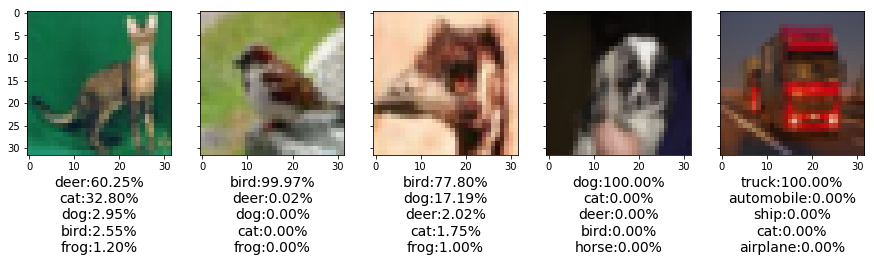

In [70]:
def get_cifar_prediction(input_image):
    #assume the input_image is 3x32x32
    
    if input_image.shape[0] != 3:
        input_image = input_image.transpose(2,0,1)
        
    input_image = np.expand_dims(input_image,0)
    input_image = torch.tensor(np.array(input_image,dtype=np.float32)).cuda()
    forward_output = model.forward(input_image).detach()
    scores = torch.softmax(forward_output,dim=1)
    prediction = torch.argmax(scores)
    
    return prediction.cpu().numpy(), scores.cpu().numpy()[0]

model.eval()
idxes = np.random.choice(10000,5)

f, ax = plt.subplots(1,5,figsize=(15,3),sharey=True)
for i in range(5):
    test_image = dataset_test[idxes[i]]['data']
    prediction,scores = get_cifar_prediction(test_image)
    max_scores_sorted = np.argsort(scores)
    ax[i].imshow(np.array(test_image,dtype=np.uint8).transpose(1,2,0))
    xlabel = '\n'.join(['%s:%.2f%%'%(meta_data[max_scores_sorted[-i]],100*scores[max_scores_sorted[-i]]) for i in range(1,6)])
    ax[i].set_xlabel(xlabel, fontsize=14)